# STA 141B: Homework 5
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name: Julia

Last Name: Stelman

Student ID: 912211657

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import osmnx as ox    
import shapely.geometry as geom

In [2]:
import sqlite3 as sql
import pandas as pd

In [3]:
db = sql.connect('sf_data.sqlite')

In [4]:
qq = """
SELECT DISTINCT A.Applicant AS Vendor, B.locationid AS Location
FROM mobile_food_schedule AS B LEFT JOIN mobile_food_permits AS A
ON A.permit = B.permit
"""
print(pd.read_sql(qq,db).shape)
tab1 = pd.read_sql(qq,db)

(679, 2)


In [5]:
VendorsQ = tab1.Vendor.unique()
VQ = list(VendorsQ)
VC = []
list(tab1.Vendor)
for vendor in VendorsQ:
    VC.append(list(tab1.Vendor).count(vendor))

counts = pd.DataFrame(list(zip(VQ,VC)))
counts.columns = ["vendor","num_locations"]
counts[counts.num_locations == counts.num_locations.max()]

,vendor,num_locations
124,May Catering,58


May Catering sells at the most locations (58 locations in total).

__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

1. What parts of the city have the most and the least noise complaints and how does that measure up to crime rate?

2. Do the vendors that sell near schools seem to target students as customers?

3. Are noise complaints and mobile food vendors related?

4. For which types of noise are complaints most common for on which days of the week, and what can we infer from that?

5. What are the most common types of food sold by mobile vendors in San Francisco?

In [58]:
sanfran = gpd.read_file("sfshapes/geo_export_80d33581-e8e7-45b5-9857-85c5ad2f2777.shp")
sanfran.head()

,link,name,geometry
0,"http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...",Seacliff,POLYGON ((-122.4934552679999 37.78351817100008...
1,None,Lake Street,POLYGON ((-122.4871507149999 37.78378542700005...
2,http://www.nps.gov/prsf/index.htm,Presidio National Park,POLYGON ((-122.4775801709999 37.81099311300005...
3,None,Presidio Terrace,POLYGON ((-122.4724105299999 37.78734653900005...
4,http://www.sfgate.com/neighborhoods/sf/innerri...,Inner Richmond,POLYGON ((-122.4726257899999 37.78631480600006...


## 1) What parts of the city have the most and the least noise complaints and how does that measure up to crime rate?

In [7]:
noise = pd.read_sql("SELECT * FROM noise ",db)
noise = noise[noise.Neighborhood==noise.Neighborhood]
noise.Neighborhood = [x.replace(r"'",'') for x in noise.Neighborhood]
lnglat = 0
lnglat = [geom.Point(x) for x in zip(noise.Lon, noise.Lat)]
noise = gpd.GeoDataFrame(noise, geometry = lnglat)
noise.head()

,CaseID,Type,Address,Neighborhood,Datetime,Lat,Lon,geometry
1,6446138,amplified_sound_electronics,Intersection of CLINTON PARK and GUERRERO ST,Mission Dolores,2016-10-21 13:20:18,37.769148,-122.424475,POINT (-122.424474850717 37.7691482064722)
2,5929789,other_excessive_noise,"1301 48TH AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 11:38:59,37.762047,-122.508365,POINT (-122.508365256702 37.762047023755)
3,5659943,other_excessive_noise,"736 LEAVENWORTH ST, SAN FRANCISCO, CA, 94109",Lower Nob Hill,2016-03-13 01:18:27,37.787983,-122.414943,POINT (-122.414943216196 37.787982901643)
4,5930704,other_excessive_noise,"1360 43RD AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 13:58:43,37.761385,-122.502232,POINT (-122.502232253358 37.76138549134)
5,6427526,construction_private_property,"108 VIRGINIA AVE, SAN FRANCISCO, CA, 94110",Bernal Heights,2016-10-17 07:28:37,37.742435,-122.420087,POINT (-122.420087435923 37.742435250569)


In [8]:
joind = gpd.sjoin(noise, sanfran, how = "inner", op = "within")
joined = joind.drop(['link','index_right'],axis=1)

In [9]:
crime = pd.read_sql("SELECT Category, Descript AS Desc, DayOfWeek, Datetime, PdDistrict, Lon, Lat FROM crime ",db)
lnglat = 0
lnglat = [geom.Point(x) for x in zip(crime.Lon, crime.Lat)]
crime = gpd.GeoDataFrame(crime, geometry = lnglat)
crime.head()
joind1 = gpd.sjoin(crime, sanfran, how = "inner", op = "within")
joined1crime = joind1.drop(['link','index_right'],axis=1)
joined1crime.head(3)

,Category,Desc,DayOfWeek,Datetime,PdDistrict,Lon,Lat,geometry,name
0,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19 14:00:00,MISSION,-122.421582,37.761701,POINT (-122.42158168137 37.7617007179518),Mission Dolores
89,DRUNKENNESS,UNDER INFLUENCE OF ALCOHOL IN A PUBLIC PLACE,Sunday,2015-02-01 20:00:00,MISSION,-122.430495,37.764342,POINT (-122.430494795393 37.76434185816321),Mission Dolores
90,ASSAULT,THREATENING SCHOOL OR PUBLIC EMPLOYEE,Sunday,2015-02-01 20:00:00,MISSION,-122.430495,37.764342,POINT (-122.430494795393 37.76434185816321),Mission Dolores


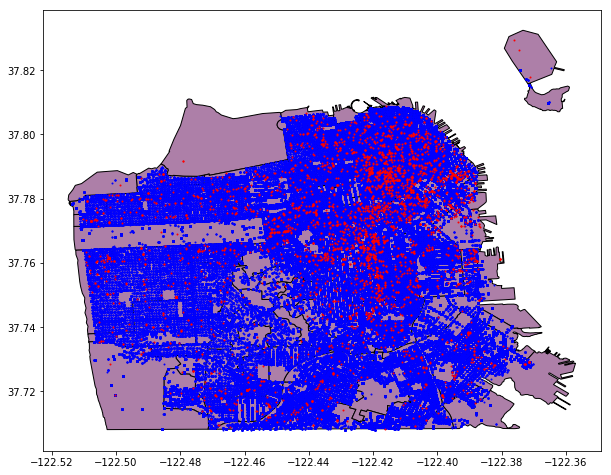

In [10]:
sfplot = sanfran.plot(figsize = (10, 10), edgecolor = "black", color = "#ad7fa8")
crime.plot(ax = sfplot, marker = 'o',color = 'blue', markersize =1,)
noise.plot(ax = sfplot, marker = 'o',color = 'red', markersize =1)
plt.show()

There might be a correlation between noise compaints and crime, but the concentration of crime is so thick in most areas that it's hard to tell past a certain point how many blue dots are in a space. There has to be a different way to approach this. Certain areas however stick out for having rather few red and or blue dots. Some neighborhoods seem to be almost free of them, while the neighborhoods they are next to seem to be full of them. 

In [12]:
specials2 = list(sanfran.name.copy())
for i in list(joined.name.unique()):     # list neighborhoods with no noise complaints
    specials2.remove(i) 

print(specials2)   # there are 5

['Yerba Buena Island', 'Monterey Heights', 'McLaren Park', 'Apparel City', 'Forest Knolls']


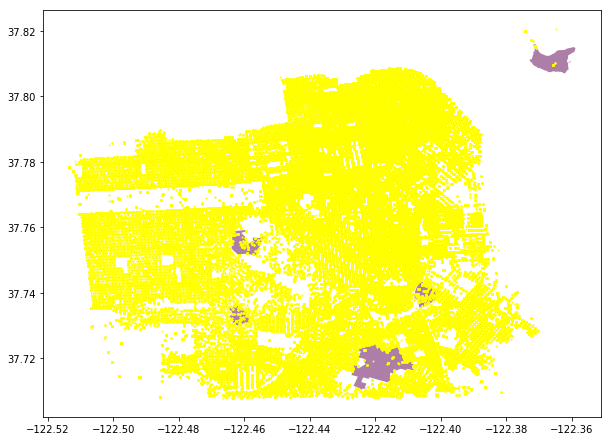

In [13]:
sfnoise2 = sanfran[sanfran.name.isin(specials2)]
sfn2 = sfnoise2.plot(figsize = (10, 10), color = "#ad7fa8")
crime.plot(ax = sfn2, marker = 'o',color = 'yellow', markersize =1,)

In [59]:
specials = list(sanfran.name.copy())
for i in list(joined1crime.name.unique()):   # list neighborhoods with no crime reports
    if len(list(joined1crime.name[joined1crime.name==i]))<50:
        continue
    else:
        specials.remove(i) 

print(specials)   # :o there are none

['Presidio National Park']


In [ ]:
foodItems = f.FoodItems.copy()
momo = list(set(foodItems))
mimi = []
for x in momo:
    if len(list(foodItems[foodItems==x]))<2:
        continue
    else:
        mimi.append(x)
mimi = pd.Series(mimi)
objects = tuple(set(mimi))
y_pos = np.arange(len(objects))
jackson = []
for x in objects:
    jackson.append(foodItems[foodItems==x].size)

plt.barh(y_pos, jackson, align='center', alpha=0.95,color = "r")
plt.yticks(y_pos, objects)

plt.xlabel('# noise complaints')
plt.title('Noise complaint reported near mobile food location frequencies per type of noise')
plt.ylabel("Type of noise")
plt.show()
len(mimi)

I was aiming to map the noise complaints over the neighborhoods where there was no crime and the crime reports over the neighborhoods where there were no noise complaints. However, there weren't any neighborhoods completely free of crime. I changed the threshold from 0 to five to ten, all the way up to fifty, and still, only only one neighborhood could make the cut. (Despite its close proximity to ALcatraz, it was the Presidio National Park "neighborhood".) However, there were five neighborhoods with no noise complaints. In the end, due to this, I decided just to do the latter half of the examiniation. 

Above you will see a plot that shows the locations of crime in San Francisco in yellow, and beneath it, there are some purple shapes which fill in the the areas of neighborhoods in San Francisco for which there are no records of noise complaints. (For the record, there are only five purple shapes - none of them are hidden under a sea of yellow dots). The fact that we can see all the purple shapes means that noise and crime are definitely not inversely proportional. I think if I were to use a higher threshold than zero, it's likely that I would find that the whiter areas on the figure would be some the next ones to turn purple. 

However, if you look at the first map (the purple one with the red and blue dots) you can get a good idea of what to expect. The areas with sparse blue dots tend to have even fewer red dots. It's also unfair that five of them are national parks, and people aren't actually allowed to live there, so it's not like a lot of robberies or noise complaints would happen when there are any homes to steel from or homeowners to call in complaining about noise.

## 2) Do the vendors that sell near schools seem to target students as customers?


In [14]:
def goodgrief(x,name,num):
    y = 'a'
    for char in name.iloc[x,num]:
        if char in ('.:;/-&!?,('):
            name.iloc[x,num] = y[1:]
            break
        y = y+char

In [15]:
def daytype(x, name, num):
    if name.iloc[x,num] in ('Sa','Su'):
        name.iloc[x,num] = "Wknd"
    if name.iloc[x,num] in ('Mo','Tu','We','Th','Fr'):
        name.iloc[x,num] = "Wkdy"

,Vendor,fi,ft,lat,lng,School,type,Day,TDay,start,end,geometry
0,D & T Catering,cold truck,Truck,37.8038,-122.4241,Galileo High School,9-12,Fr,Wkdy,0,13,POINT (-122.4241 37.8038)


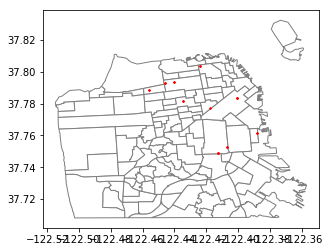

In [16]:
q2 = """
SELECT DISTINCT A.Applicant AS Vendor, FoodItems AS fi, 
A.FacilityType AS ft, ROUND(C.latitude,4) AS lat,
ROUND(C.longitude,4) AS lng, D.Name AS School,
D.GradeRange AS type, B.DayOfWeek AS Day, B.DayOfWeek AS TDay,
B.StartHour AS start, B.EndHour AS end
FROM schools AS D INNER JOIN mobile_food_locations AS C INNER JOIN mobile_food_permits AS A
INNER JOIN mobile_food_schedule AS B
ON A.permit = B.permit AND B.locationid = C.locationid AND ROUND(C.latitude,4) = ROUND(D.Lat,4)
AND ROUND(C.longitude,4) = ROUND(D.Lon,4) 
"""
tab = pd.read_sql(q2,db)
tab = tab.loc[tab.lat!=0]
tab = tab.loc[tab.lng!=0]
tab.index = pd.Series(range(len(tab.index)))
tab.fi = tab.fi.str.lower()
pd.Series(range(len(list(tab.fi)))).apply(lambda x: goodgrief(x,name = tab, num = 1))
pd.Series(range(len(list(tab.fi)))).apply(lambda x: daytype(x,name = tab, num = 8))
lnglat = [geom.Point(x) for x in zip(tab.lng, tab.lat)]
geotab = gpd.GeoDataFrame(tab.copy(), geometry = lnglat)
ax = sanfran.plot(color = "white", edgecolor = "gray")
geotab.plot(ax = ax, marker='o', color='red', markersize=1)

geotab.head(1)

I am suspicious about the consistency of the time column. The very first entry appears to claim that they are stationed from midnight to in the afternoon on the same day. That's highly unbelievable. If the time is supposed to be 24 hours, then some vendors are selling hot dogs from 6 am to noon. (Not prime hotdog selling time if you ask me.) If the time is not 24 hours, then 6 of the 16 records span impossible timeframes. I wish I could use time as a variable, but unfortunately, it's acting pretty shady in the data so I'll have to remove it before further analysis.

In [17]:
tabr = tab.copy().drop(['ft','lat','lng','start','end'],axis = 1).drop_duplicates()
tabr.index = pd.Series(range(len(tabr.index)))

In [18]:
print(set(tabr[tabr.TDay == "Wkdy"]['Vendor']) == set(tabr['Vendor']))  #True ==> every vendor sells on at least one weekday
print(tabr.shape[0] - tabr[tabr.TDay == "Wkdy"].shape[0])   #6 ==> only six points were removed 
print(len(set(tabr.Vendor[tabr.TDay == "Wknd"])))  #2 ==> only 2 vendors were selling on weekends to begin with
print(len(set(tabr.Vendor)))  #6 ==> 6 vendors sell near schools on weekdays, including 2 that also sell near schools on weekends

True
6
2
6


I didn't notice many weekends showing up. When weekends were removed, the dataset went from 50 rows to 44, but no vendors were dropped from the set. Upon further examination, I fount that out of six distinct vendors, two were responsible for all food truck opperation at near-school locations on weekends. Hence, I decided that the fact that two vendors sell on weekends in addition to weekdays doesn't make for strong supportive evidence. 

[Text(0,0.5,'Count'),
 Text(0.5,0,'GradeRange'),
 Text(0.5,1,'Vendors / GradeRange')]

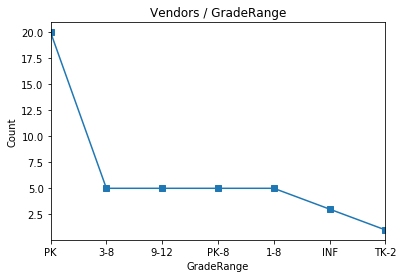

In [19]:
counts = tabr[tabr.TDay == "Wkdy"]['type'].value_counts()
ax = counts.plot(style = "-s")
ax.set(title = "Vendors / GradeRange", xlabel = "GradeRange", ylabel = "Count")

In [20]:
def studenttype(x, name, num):
    if name.iloc[x,num] in ("PK","INF","TK-2"):
        name.iloc[x,num] = 'Tots: p = 0'   # infants, toddlers, and children thru grade 2 don't buy st food
    if name.iloc[x,num] in ("PK-8","1-8","3-8"):
        name.iloc[x,num] = 'thru eighth: p = 1'   # older half of student body after class have potential
    if name.iloc[x,num] in ("9-12"):
        name.iloc[x,num] = 'high school: p = 2'   # high schools during lunch and after class have lots of potential

[Text(0,0.5,'Q = sum(i,j,k):{vendor.j at school.i on wkdy.k}'),
 Text(0.5,0,'P = potential students have freedom and money to be customers'),
 Text(0.5,1,"Vendors / Students' Potential as Target Customers")]

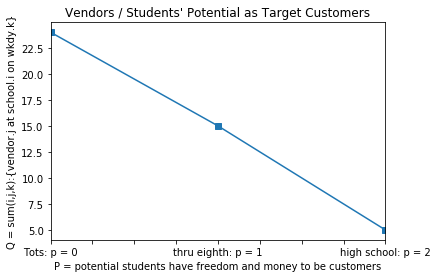

In [21]:
tabr2 = tabr.copy()[tabr.TDay == "Wkdy"]
pd.Series(range(len(list(tabr2.type)))).apply(lambda x: studenttype(x,name = tabr2, num = 3))
counts2 = tabr2['type'].value_counts()
ax = counts2.plot(style = "-s")
ax.set(title = "Vendors / Students' Potential as Target Customers", 
       xlabel = "P = potential students have freedom and money to be customers", 
       ylabel = "Q = sum(i,j,k):{vendor.j at school.i on wkdy.k}")

Based on the plots and the numbers, I infer that that vendors who sell near schools don't do so to profit from sales to students. A huge proportion of the counts (Q for quantity) pertain to schools with student bodies that provide virtually no potential consumers because their students are at most 7 years old (p=0). Meanwhile, on the other side, only a small proportion of the counts pertain to schools with student bodies that provide virtually only potential consumers.

All in all, I've come to the conclusion that vendors don't sell near schools to target students. 

## 3) Are noise complaints and mobile food vendors related?


In [24]:
q = """
SELECT A.Applicant AS Vendor, lower(A.FoodItems) AS Items, B.locationid AS Location,
A.FacilityType AS Vehicle, C.latitude AS lat, C.longitude AS lng
FROM mobile_food_locations AS C LEFT JOIN mobile_food_permits AS A LEFT JOIN mobile_food_schedule AS B
ON A.permit = B.permit AND B.locationid = C.locationid
"""
food = pd.read_sql(q,db)
food = food.loc[food.lng!=0].dropna(axis = 0,how='any')
foodindex = pd.Series(range(len(food.index)))
pd.Series(range(len(list(food.Items)))).apply(lambda x: goodgrief(x=x, name = food, num = 1))
food.head(2)

,Vendor,Items,Location,Vehicle,lat,lng
0,F & C Catering,cold truck,762182.0,Truck,37.774871,-122.398532
1,F & C Catering,cold truck,762182.0,Truck,37.774871,-122.398532


In [25]:
lnglat = [geom.Point(x) for x in zip(food.lng, food.lat)]
food = gpd.GeoDataFrame(food, geometry = lnglat)
food.head()

,Vendor,Items,Location,Vehicle,lat,lng,geometry
0,F & C Catering,cold truck,762182.0,Truck,37.774871,-122.398532,POINT (-122.398531708276 37.7748713162388)
1,F & C Catering,cold truck,762182.0,Truck,37.774871,-122.398532,POINT (-122.398531708276 37.7748713162388)
2,F & C Catering,cold truck,762182.0,Truck,37.774871,-122.398532,POINT (-122.398531708276 37.7748713162388)
3,F & C Catering,cold truck,762182.0,Truck,37.774871,-122.398532,POINT (-122.398531708276 37.7748713162388)
4,F & C Catering,cold truck,762182.0,Truck,37.774871,-122.398532,POINT (-122.398531708276 37.7748713162388)


(37.7, 37.84)

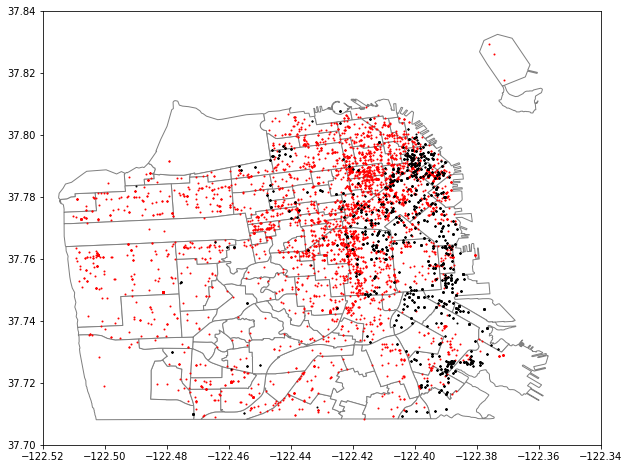

In [26]:
# Make the plot.
ax = sanfran.plot(color = "white", edgecolor = "gray",figsize = (10,10))
noise.plot(ax = ax, marker = 'o',color = 'red', markersize =1)
food.plot(ax = ax, marker='o', color='black', markersize=1)

#Set x and y limits to adjust the "zoom".
ax.set_xlim([-122.52, -122.34])
ax.set_ylim([37.7, 37.84])

In [27]:
q = """
SELECT DISTINCT A.Applicant AS Vendor, lower(A.FoodItems) AS Items, B.locationid AS Location,
A.FacilityType AS Vehicle, ROUND(C.latitude,3) AS lat, ROUND(C.longitude,3) AS lng,
D.Type AS complaint, D.Neighborhood AS hood, B.EndHour AS endhour, D.Datetime as date
FROM mobile_food_locations AS C LEFT JOIN mobile_food_permits AS A LEFT JOIN mobile_food_schedule AS B
INNER JOIN noise AS D
ON A.permit = B.permit AND B.locationid = C.locationid AND ROUND(C.latitude,3) = ROUND(D.Lat,3) 
AND ROUND(C.longitude,3) = ROUND(D.Lon,3)
"""
fooey = pd.read_sql(q,db)
food3noise = pd.read_sql(q,db)
food3noise = food3noise.loc[food3noise.lng!=0].dropna(axis = 0,how='any')
food3noiseindex = pd.Series(range(len(food3noise.index)))
pd.Series(range(len(list(food3noise.Items)))).apply(lambda x: goodgrief(x=x, name = food3noise, num = 1))
food3noise.head(2)

,Vendor,Items,Location,Vehicle,lat,lng,complaint,hood,endhour,date
0,F & C Catering,cold truck,762182,Truck,37.775,-122.399,construction_private_property,South of Market,11,2016-11-04 14:55:49
1,Singh Brothers Ice Cream,ice cream,765527,Truck,37.720,-122.389,other_excessive_noise,Bret Harte,15,2016-07-04 17:43:47


In [28]:
lnglat = [geom.Point(x) for x in zip(food3noise.lng, food3noise.lat)]
food3noise = gpd.GeoDataFrame(food3noise, geometry = lnglat)
food3noise.head(2)

,Vendor,Items,Location,Vehicle,lat,lng,complaint,hood,endhour,date,geometry
0,F & C Catering,cold truck,762182,Truck,37.775,-122.399,construction_private_property,South of Market,11,2016-11-04 14:55:49,POINT (-122.399 37.775)
1,Singh Brothers Ice Cream,ice cream,765527,Truck,37.720,-122.389,other_excessive_noise,Bret Harte,15,2016-07-04 17:43:47,POINT (-122.389 37.72)
2,"Off the Grid Services, LLC",everything,761934,Truck,37.781,-122.393,delivery_service_business,South Beach,15,2017-02-22 15:05:17,POINT (-122.393 37.781)
3,Roadside Rotisserie Corporation / Country Grill,rotisserie chicken,763522,Truck,37.791,-122.400,other_excessive_noise,Financial District,15,2017-01-30 12:50:21,POINT (-122.4 37.791)
4,Sun Rise Catering,cold truck,509478,Truck,37.778,-122.408,mechanical_equipment,South of Market,10,2016-04-30 21:48:33,POINT (-122.408 37.778)


(37.7, 37.84)

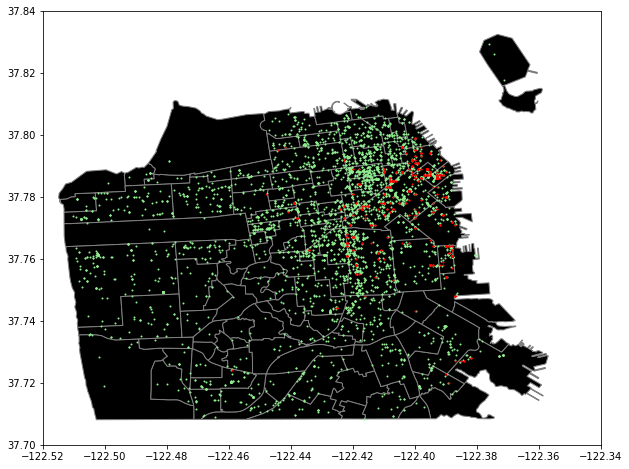

In [29]:
# Make the plot.
ax = sanfran.plot(color = "black", edgecolor = "gray",figsize = (10,10))
noise.plot(ax = ax, marker = 'o',color = 'lightgreen', markersize =1)
food3noise.plot(ax = ax, marker='o', color='red', markersize=1)
#food.plot(ax = ax, marker='o', color='black', markersize=1)

#Set x and y limits to adjust the "zoom".
ax.set_xlim([-122.52, -122.34])
ax.set_ylim([37.7, 37.84])

(37.7, 37.84)

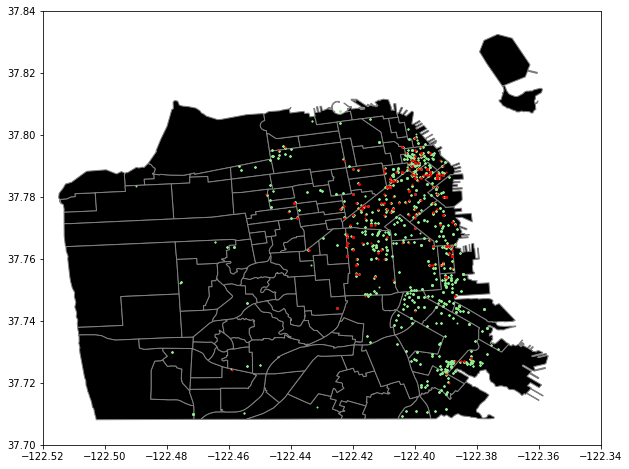

In [30]:
# Make the plot.
ax = sanfran.plot(color = "black", edgecolor = "gray",figsize = (10,10))
food.plot(ax = ax, marker = 'o',color = 'lightgreen', markersize =1)
food3noise.plot(ax = ax, marker='o', color='red', markersize=1)
#food.plot(ax = ax, marker='o', color='black', markersize=1)

#Set x and y limits to adjust the "zoom".
ax.set_xlim([-122.52, -122.34])
ax.set_ylim([37.7, 37.84])

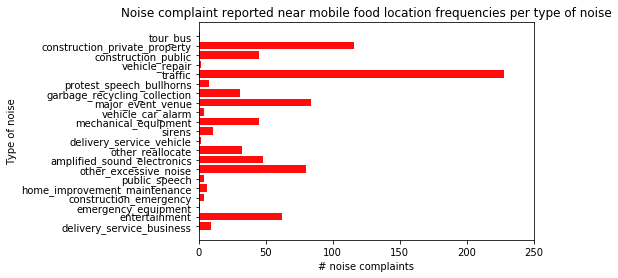

In [31]:
objects = tuple(set(food3noise.complaint))
y_pos = np.arange(len(objects))
jackson = []
for x in objects:
    jackson.append(food3noise.complaint[food3noise.complaint==x].size)

plt.barh(y_pos, jackson, align='center', alpha=0.95,color = "r")
plt.yticks(y_pos, objects)
plt.xlim(0,250)
plt.xlabel('# noise complaints')
plt.title('Noise complaint reported near mobile food location frequencies per type of noise')
plt.ylabel("Type of noise")
plt.show()


## 4) What are the most common types of food sold by mobile vendors in San Francisco?

In [22]:
f = pd.read_sql("SELECT DISTINCT Applicant, lower(FoodItems) AS FoodItems, FacilityType FROM mobile_food_permits",db)
f = f.dropna(axis = 0,how='any')
f.index = pd.Series(range(len(f.index)))
pd.Series(range(len(list(f.FoodItems)))).apply(lambda x: goodgrief(x=x, name = f, num = 1))
f.FoodItems = f.FoodItems.str.lower()

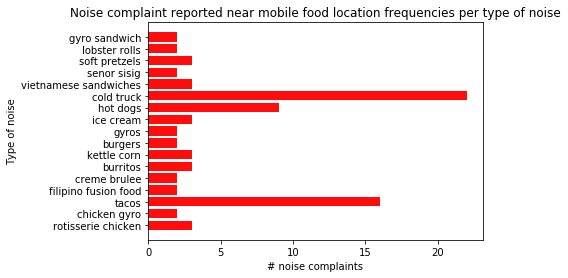

17

In [48]:
foodItems = f.FoodItems.copy()
momo = list(set(foodItems))
mimi = []
for x in momo:
    if len(list(foodItems[foodItems==x]))<2:
        continue
    else:
        mimi.append(x)
mimi = pd.Series(mimi)
objects = tuple(set(mimi))
y_pos = np.arange(len(objects))
jackson = []
for x in objects:
    jackson.append(foodItems[foodItems==x].size)

plt.barh(y_pos, jackson, align='center', alpha=0.95,color = "r")
plt.yticks(y_pos, objects)

plt.xlabel('# noise complaints')
plt.title('Noise complaint reported near mobile food location frequencies per type of noise')
plt.ylabel("Type of noise")
plt.show()
len(mimi)

## 5) For which types of noise are complaints most common for on which days of the week, and what can we infer from that?

In [33]:
def year_to_anchor(year):
    c = year//100
    a = (5*(c%4)+2)%7
    return a

def year_to_doomsday(year):
    a = year_to_anchor(year)
    y = year%100
    d = (y + (y//4) + a)%7
    return d

def date_to_weekday(month, day, year):
    d = year_to_doomsday(year)
    
    #leap years
    #assuming tanner is correct (see slack #questions)
    if (month == 1 or month == 2) and ((year%4 == 0 and not year%100 == 0) or year%400 == 0):
        day = day-1

    #now for the month specific doomsdates
    if month == 1:
        x = (day-10)%7
    if month == 2:
        x = (day-28)%7
    if month == 3:
        x = (day-21)%7
    if month == 4:
        x = (day-4)%7
    if month == 5:
        x = (day-9)%7
    if month == 6:
        x = (day-6)%7
    if month == 7:
        x = (day-11)%7
    if month == 8:
        x = (day-8)%7
    if month == 9:
        x = (day-5)%7
    if month == 10:
        x = (day-10)%7
    if month == 11:
        x = (day-7)%7
    if month == 12:
        x = (day-12)%7
    if month < 1 or month > 12:
        print("invalid month")
        return None
    
    #for determining day code
    daycode = (x + d)%7
    
    #for determining day
    if daycode == 0:
        wd = "Sunday"
    if daycode == 1:
        wd = "Monday"
    if daycode == 2:
        wd = "Tuesday"
    if daycode == 3:
        wd = "Wednesday"
    if daycode == 4:
        wd = "Thursday"
    if daycode == 5:
        wd = "Friday"
    if daycode == 6:
        wd = "Saturday"
    return wd

In [34]:
tess = fooey.copy().date.get_values()
for x in range(len(tess)):
    tess[x] = tess[x][:10]
    tess[x] = tess[x].split("-")
#[yr, mon, day]
tesswkd = []
for x in tess:
    mon,day,yr = int(x[1]),int(x[2]),int(x[0])
    tesswkd.append(date_to_weekday(mon, day, yr))
tesswkd[:7]
twd = pd.Series(tesswkd)
ttt = pd.DataFrame({"complaint": fooey.complaint.values, "weekday": twd}, index = pd.Series(range(twd.size)))

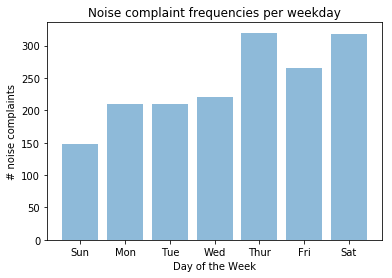

In [35]:
objects = ("Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday")
y_pos = np.arange(len(objects))
performance = []
for x in objects:
    performance.append(ttt[ttt.weekday==x].size)

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, ("Sun","Mon","Tue","Wed","Thur","Fri","Sat"))
plt.ylabel('# noise complaints',)
plt.title('Noise complaint frequencies per weekday')
plt.xlabel("Day of the Week")
plt.show()

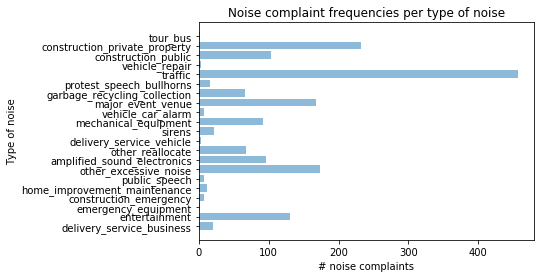

In [36]:
objects = tuple(set(ttt.complaint))
y_pos = np.arange(len(objects))
performance = []
for x in objects:
    performance.append(ttt[ttt.complaint==x].size)

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('# noise complaints',)
plt.title('Noise complaint frequencies per type of noise')
plt.ylabel("Type of noise")
plt.show()

In [37]:
sunda = ttt.copy()[ttt.weekday=="Sunday"]
v1 = tuple(set(sunda.complaint))
monda = ttt.copy()[ttt.weekday=="Monday"]
v2 = tuple(set(monda.complaint))
tuesd = ttt.copy()[ttt.weekday=="Tuesday"]
v3 = tuple(set(tuesd.complaint))
wedne = ttt.copy()[ttt.weekday=="Wednesday"]
v4 = tuple(set(wedne.complaint))
thurs = ttt.copy()[ttt.weekday=="Thursday"]
v5 = tuple(set(thurs.complaint))
frida = ttt.copy()[ttt.weekday=="Friday"]
v6 = tuple(set(frida.complaint))
satur = ttt.copy()[ttt.weekday=="Saturday"]
v7 = tuple(set(satur.complaint))

objects = tuple(set(ttt.complaint))
v1=[]
for x in objects:
    v1.append(sunda[sunda.complaint==x].size)
v2 = []
for x in objects:
    v2.append(monda[monda.complaint==x].size)
v12 = tuple(pd.Series(list(zip(v1,v2))).apply(sum))
v3=[]
for x in objects:
    v3.append(tuesd[tuesd.complaint==x].size)
v123 = tuple(pd.Series(list(zip(v1,v2,v3))).apply(sum))
v4=[]
for x in objects:
    v4.append(wedne[wedne.complaint==x].size)
v1234 = tuple(pd.Series(list(zip(v1,v2,v3,v4))).apply(sum))
v5=[]
for x in objects:
    v5.append(thurs[thurs.complaint==x].size)
v12345 = tuple(pd.Series(list(zip(v1,v2,v3,v4,v5))).apply(sum))
v6=[]
for x in objects:
    v6.append(frida[frida.complaint==x].size)
v123456 = tuple(pd.Series(list(zip(v1,v2,v3,v4,v5,v6))).apply(sum))
v7=[]
for x in objects:
    v7.append(satur[satur.complaint==x].size)

N = 21
ind = np.arange(N)    # the x locations for the groups
width = 0.85       # the width of the bars: can also be len(x) sequence

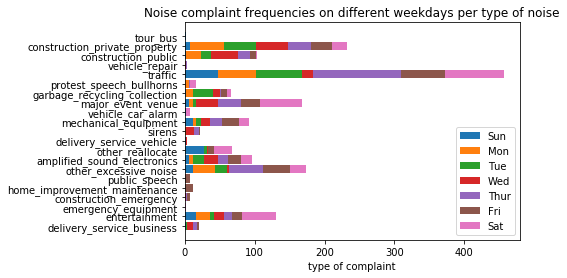

In [38]:
p1 = plt.barh(ind, v1, width)
p2 = plt.barh(ind, v2, width,left=v1)
p3 = plt.barh(ind, v3, width,left=v12)
p4 = plt.barh(ind, v4, width,left=v123)
p5 = plt.barh(ind, v5, width,left=v1234)
p6 = plt.barh(ind, v6, width,left=v12345)
p7 = plt.barh(ind, v7, width,left=v123456)
plt.xlabel('type of complaint')
plt.title('Noise complaint frequencies on different weekdays per type of noise')
plt.yticks(ind, objects)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0]), ('Sun', 'Mon','Tue','Wed','Thur','Fri','Sat'))
plt.show()

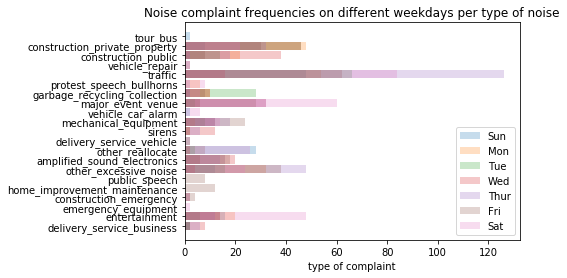

In [39]:
p1 = plt.barh(ind, v1, width,alpha = 0.25)
p2 = plt.barh(ind, v2, width,alpha = 0.25)
p3 = plt.barh(ind, v3, width,alpha = 0.25)
p4 = plt.barh(ind, v4, width,alpha = 0.25)
p5 = plt.barh(ind, v5, width,alpha = 0.25)
p6 = plt.barh(ind, v6, width,alpha = 0.25)
p7 = plt.barh(ind, v7, width,alpha = 0.25)

plt.xlabel('type of complaint')
plt.title('Noise complaint frequencies on different weekdays per type of noise')
plt.yticks(ind, objects)
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0]), ('Sun', 'Mon','Tue','Wed','Thur','Fri','Sat'))
plt.show()

In [40]:
db.close()